In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/data.zip

Archive:  /content/drive/MyDrive/data.zip
   creating: data/
   creating: data/BrainTumor/
  inflating: data/BrainTumor/Cancer (1).jpg  
  inflating: data/BrainTumor/Cancer (10).jpg  
  inflating: data/BrainTumor/Cancer (10).tif  
  inflating: data/BrainTumor/Cancer (1000).jpg  
  inflating: data/BrainTumor/Cancer (1001).jpg  
  inflating: data/BrainTumor/Cancer (1003).jpg  
  inflating: data/BrainTumor/Cancer (1007).jpg  
  inflating: data/BrainTumor/Cancer (1008).jpg  
  inflating: data/BrainTumor/Cancer (101).jpg  
  inflating: data/BrainTumor/Cancer (1013).JPG  
  inflating: data/BrainTumor/Cancer (1017).jpg  
  inflating: data/BrainTumor/Cancer (1018).jpg  
  inflating: data/BrainTumor/Cancer (102).jpg  
  inflating: data/BrainTumor/Cancer (1021).jpg  
  inflating: data/BrainTumor/Cancer (1025).JPG  
  inflating: data/BrainTumor/Cancer (1027).JPG  
  inflating: data/BrainTumor/Cancer (103).jpg  
  inflating: data/BrainTumor/Cancer (1033).jpg  
  inflating: data/BrainTumor/Cancer (

In [3]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms


class CustomImageDataset(Dataset):
    def read_data_set(self):

        all_img_files = []
        all_labels = []

        class_names = os.walk(self.data_set_path).__next__()[1]

        for index, class_name in enumerate(class_names):
            label = index
            img_dir = os.path.join(self.data_set_path, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                if img is not None:
                    all_img_files.append(img_file)
                    all_labels.append(label)

        return all_img_files, all_labels, len(all_img_files), len(class_names)

    def __init__(self, data_set_path, transforms=None):
        self.data_set_path = data_set_path
        self.image_files_path, self.labels, self.length, self.num_classes = self.read_data_set()
        self.transforms = transforms

    def __getitem__(self, index):
        image = Image.open(self.image_files_path[index])
        image = image.convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)

        return image, self.labels[index]

    def __len__(self):
        return self.length

In [55]:
transforms_train = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomRotation(10.),
                                       transforms.ToTensor()])

train_data_set = CustomImageDataset(data_set_path="/content/data", transforms=transforms_train)
train_loader = DataLoader(train_data_set, batch_size=16, shuffle=True)

In [56]:
batch=next(iter(train_loader))

In [57]:
len(batch)

2

In [58]:
type(batch)

list

In [59]:
images = batch[0]
labels = batch[1]

In [60]:
images.shape

torch.Size([16, 3, 128, 128])

In [61]:
labels.shape

torch.Size([16])

In [62]:
labels

tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1])

labels : tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1])


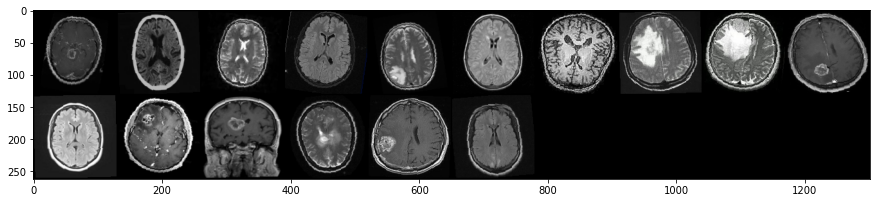

In [63]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images,nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print(f"labels : {labels}")

In [64]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [97]:
class CustomNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16,32, kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(32, 64, kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64 ,128, kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(139392,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,2)
        )
    
    def forward(self, xb):
        return self.network(xb)


In [98]:
network2 = CustomNetwork()
print(network2)

CustomNetwork(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=139392, out_features=1024, bias=True)
    (12): ReLU()
    (13): Linear(in_features=1024, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [99]:
network2.cuda()

CustomNetwork(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=139392, out_features=1024, bias=True)
    (12): ReLU()
    (13): Linear(in_features=1024, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [100]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [101]:
device

device(type='cuda', index=0)

In [102]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [103]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network2.parameters(), lr=0.1)

for epoch in range(50):
    total_loss = 0
    total_correct = 0
    for i, item in enumerate(train_loader):
        images = item[0].to(device)
        labels = item[1].to(device)

        preds = network2(images)
        loss = F.cross_entropy(preds,labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_correct += get_num_correct(preds,labels)

    avg_loss = total_loss / len(train_loader)
    print("epoch:",epoch,"total_correct:",total_correct,"loss:",avg_loss)

epoch: 0 total_correct: 2344 loss: 101116.9588837726
epoch: 1 total_correct: 2395 loss: 0.698803647628261
epoch: 2 total_correct: 2455 loss: 0.6945536449137661
epoch: 3 total_correct: 2363 loss: 0.7059736816833416
epoch: 4 total_correct: 2327 loss: 0.7003971005065573
epoch: 5 total_correct: 2415 loss: 0.6953954011615779
epoch: 6 total_correct: 2409 loss: 0.6992918646170033
epoch: 7 total_correct: 2365 loss: 0.7056150736494197
epoch: 8 total_correct: 2335 loss: 0.7028475405855311
epoch: 9 total_correct: 2399 loss: 0.6960406818737587
epoch: 10 total_correct: 2399 loss: 0.7021646731429629
epoch: 11 total_correct: 2443 loss: 0.6961617680887381
epoch: 12 total_correct: 2447 loss: 0.6981025187091695
epoch: 13 total_correct: 2375 loss: 0.7019095710582204
epoch: 14 total_correct: 2429 loss: 0.6978511065244675
epoch: 15 total_correct: 2447 loss: 0.695184416241116
epoch: 16 total_correct: 2425 loss: 0.7004925418231223
epoch: 17 total_correct: 2421 loss: 0.696729999449518
epoch: 18 total_correct: